# Asthma: Threshold Tuning for F1 and MCC

This notebook finds the best probability thresholds for maximizing F1 and MCC. It uses predictions from the Logistic Regression pipeline built in `Asthma_Classification.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
sns.set(style="whitegrid", context="notebook")

## Load data and train the same pipeline
We replicate the same preprocessing and model to get probabilities on a test split.

In [2]:
csv_path = r'c:\Users\bhara\Downloads\ML\3\synthetic_asthma_dataset.csv'
df = pd.read_csv(csv_path)
drop_cols = [c for c in ['Patient_ID', 'Asthma_Control_Level'] if c in df.columns]
df = df.drop(columns=drop_cols)
df = df.dropna(subset=['Has_Asthma'])
df['Has_Asthma'] = df['Has_Asthma'].astype(int)
target = 'Has_Asthma'
X = df.drop(columns=[target])
y = df[target].values
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocess = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])
clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
model = Pipeline([('preprocess', preprocess), ('clf', clf)])
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
print('Model trained and probabilities computed.')

Model trained and probabilities computed.


## Threshold sweep
We evaluate F1, MCC, Precision, and Recall across thresholds in [0,1].

In [3]:
def metrics_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    return {
        'threshold': thr,
        'f1': f1_score(y_true, y_hat, zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_hat),
        'precision': precision_score(y_true, y_hat, zero_division=0),
        'recall': recall_score(y_true, y_hat, zero_division=0)
    }
thresholds = np.linspace(0.0, 1.0, 201)
rows = [metrics_at_threshold(y_test, y_proba, t) for t in thresholds]
sweep = pd.DataFrame(rows)
sweep.head()

,threshold,f1,mcc,precision,recall
0,0.000,0.391637,0.000000,0.243500,1.0
1,0.005,0.522813,0.382057,0.353924,1.0
2,0.010,0.550905,0.425045,0.380172,1.0
3,0.015,0.569258,0.451736,0.397876,1.0
4,0.020,0.584634,0.473434,0.413062,1.0


## Best thresholds
Select thresholds maximizing F1 and MCC.

In [4]:
best_f1_row = sweep.loc[sweep['f1'].idxmax()]
best_mcc_row = sweep.loc[sweep['mcc'].idxmax()]
best_f1_thr = float(best_f1_row['threshold'])
best_mcc_thr = float(best_mcc_row['threshold'])
print('Best F1 threshold:', best_f1_thr, 'F1=', best_f1_row['f1'])
print('Best MCC threshold:', best_mcc_thr, 'MCC=', best_mcc_row['mcc'])

Best F1 threshold: 0.515 F1= 0.8576779026217228
Best MCC threshold: 0.515 MCC= 0.8122259536060145


## Plot metrics vs threshold
Visualize F1, MCC, Precision, Recall to see trade-offs.

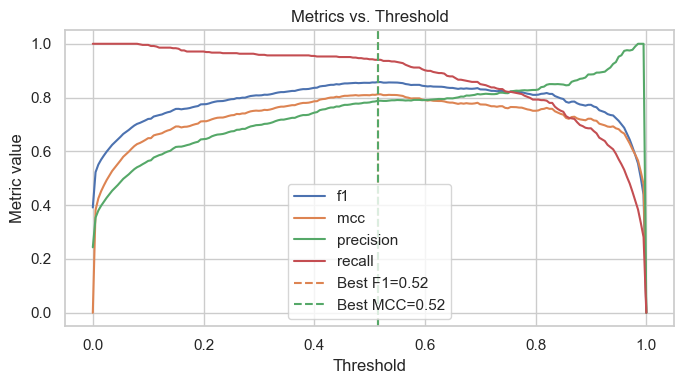

In [5]:
fig, ax = plt.subplots(figsize=(7,4))
for col in ['f1','mcc','precision','recall']:
    ax.plot(sweep['threshold'], sweep[col], label=col)
ax.axvline(best_f1_thr, color='C1', ls='--', label=f'Best F1={best_f1_thr:.2f}')
ax.axvline(best_mcc_thr, color='C2', ls='--', label=f'Best MCC={best_mcc_thr:.2f}')
ax.set_xlabel('Threshold'); ax.set_ylabel('Metric value'); ax.set_title('Metrics vs. Threshold')
ax.legend(); plt.tight_layout(); plt.show()

## Confusion matrices at chosen thresholds
Inspect confusion matrices for both chosen thresholds.

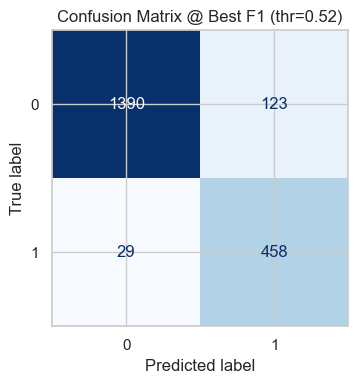

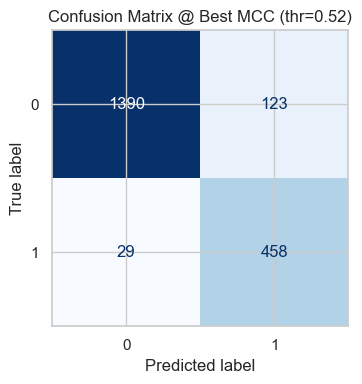

In [6]:
for name, thr in [('Best F1', best_f1_thr), ('Best MCC', best_mcc_thr)]:
    y_hat = (y_proba >= thr).astype(int)
    cm = confusion_matrix(y_test, y_hat)
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Confusion Matrix @ {name} (thr={thr:.2f})')
    plt.tight_layout(); plt.show()

## Save sweep results
We save the full threshold sweep to CSV for future reference.

In [7]:
out_csv = r'c:\Users\bhara\Downloads\ML\3\asthma_threshold_sweep.csv'
sweep.to_csv(out_csv, index=False)
print('Saved threshold sweep to', out_csv)

Saved threshold sweep to c:\Users\bhara\Downloads\ML\3\asthma_threshold_sweep.csv
